### Demo Active Learning

In [1]:
#!pip install sklearn modAL

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [2]:
# load dataset
iris = load_iris()

X_raw = iris['data']
y_raw = iris['target']
print(f'len raw datasets {X_raw.shape[0]}')

len raw datasets 150


In [3]:
# split dataset
n_labeled_examples = X_raw.shape[0]
training_indices = np.random.randint(low=0, high=n_labeled_examples + 1, size=5)

X_train = X_raw[training_indices]
y_train = y_raw[training_indices]

# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(y_raw, training_indices, axis=0)

print(f'Initial dataset, len:{X_train.shape[0]}')

Initial dataset, len:5


In [4]:
def loop(learner, X_pool, y_pool, performance_history, n_iteration=10):
    """
    Args:
        learner: object modAL.
        X_pool: features dataset.
        y_pool: features labels.
        performance_history: list of metrics.
    """
    for index in range(n_iteration):
        query_index, query_instance = learner.query(X_pool)
    
        # Teach our ActiveLearner model the record it has requested.
        X, y = X_pool[query_index].reshape(1, -1), y_pool[query_index].reshape(1, )
        learner.teach(X=X, y=y)

        # Remove the queried instance from the unlabeled pool.
        X_pool, y_pool = np.delete(X_pool, query_index, axis=0), np.delete(y_pool, query_index)

        # Calculate and report our model's accuracy.
        model_accuracy = learner.score(X_raw, y_raw)
        print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))

        # Save our model's performance for plotting.
        performance_history.append(model_accuracy)
        
    return learner, performance_history

In [5]:
# ModAL classifier
learner = ActiveLearner(estimator=RandomForestClassifier(),
                        query_strategy=uncertainty_sampling,
                        X_training=X_train, y_training=y_train)
# initial metrics
unqueried_score = learner.score(X_raw, y_raw)
print(f'Initial metrics {unqueried_score}')

Initial metrics 0.88


In [6]:
clf, list_history = loop(learner, X_pool, y_pool, performance_history=[unqueried_score])

Accuracy after query 1: 0.9067
Accuracy after query 2: 0.9067
Accuracy after query 3: 0.9267
Accuracy after query 4: 0.9600
Accuracy after query 5: 0.9800
Accuracy after query 6: 0.9400
Accuracy after query 7: 0.9467
Accuracy after query 8: 0.9067
Accuracy after query 9: 0.9133
Accuracy after query 10: 0.9067


In [7]:
def random_sampling(classifier, X_pool):
    query_idx = np.random.choice(range(X_pool.shape[0]))
    return query_idx, X_pool[query_idx]

In [8]:
learner_random = ActiveLearner(estimator=RandomForestClassifier(),
                               query_strategy=random_sampling,
                               X_training=X_train, y_training=y_train)

In [9]:
# initial metrics
unqueried_score = learner_random.score(X_raw, y_raw)
print(f'Initial metrics {unqueried_score}')

Initial metrics 0.88


In [10]:
clf, list_history_random = loop(learner_random, X_pool, y_pool, performance_history=[unqueried_score])

Accuracy after query 1: 0.8533
Accuracy after query 2: 0.8933
Accuracy after query 3: 0.8867
Accuracy after query 4: 0.9067
Accuracy after query 5: 0.9600
Accuracy after query 6: 0.9467
Accuracy after query 7: 0.9400
Accuracy after query 8: 0.9467
Accuracy after query 9: 0.9467
Accuracy after query 10: 0.9400


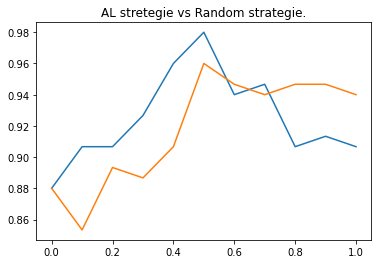

In [14]:
x1 = np.linspace(0, 1, 11)
x2 = np.linspace(0, 1, 11)
plt.plot(x1, list_history)
plt.plot(x2, list_history_random)
plt.title('AL stretegie vs Random strategie.')
plt.show()